In [2]:
import os, shutil, time
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms

%matplotlib inline

In [3]:
# model name
model_name = 'resnet-custom-'

## Redo att köras

# Resnet model with MSELoss

## Prepare dataset

In [ ]:
# Download data
# ! wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
# ! tar -xzf testSetPlaces205_resize.tar.gz   
! ls

Directory `testSet_resize` most be in root

In [ ]:
# install libraries
# !pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

In [3]:
# Split into train and validation
os.makedirs('images/train/class/', exist_ok=True)
os.makedirs('images/val/class/', exist_ok=True)
for i, file in enumerate(os.listdir('testSet_resize')):
    if i < 1000:
        os.rename('testSet_resize/' + file, 'images/val/class/' + file) # 1k images
    else:
        os.rename('testSet_resize/'+ file, 'images/train/class/' + file) # 40k images

In [7]:
# Make small subset for testing
# shutil.copy2('/src/file.ext', '/dst/dir')
os.makedirs('images/sub_train/class/', exist_ok=True)
os.makedirs('images/sub_val/class/', exist_ok=True)

for i, file in enumerate(os.listdir('images/train/class')):
    shutil.copy2('images/train/class/' + file, 'images/sub_train/class') # 400 images
    if i >= 400:
        break

for i, file in enumerate(os.listdir('images/val/class')):
    shutil.copy2('images/val/class/' + file, 'images/sub_val/class') # 10 images
    if i >= 10:
        break

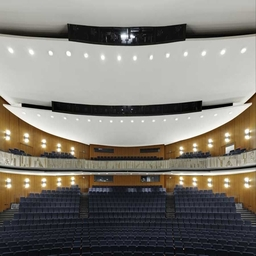

In [8]:
# Show an image
display(Image(filename='images/val/class/504be791e546a6a669d64989a4c3246b.jpg'))

## Model

In [29]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

False


In [30]:
# Model
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128

        ## First half: ResNet
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        ## Second half: Upsampling
        self.upsample = nn.Sequential(     
          nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )

    def forward(self, input):
        # Pass input through ResNet-gray to extract features
        midlevel_features = self.midlevel_resnet(input)

        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output

In [31]:
model = ColorizationNet()

In [32]:
# Loss function
# criterion = nn.MSELoss()

alpha = 0.005

def criterion(trained, target):
    MSE = torch.mean((trained - target) ** 2)
    return (MSE + alpha / trained.std()), MSE

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

## Dataset

In [34]:
# Make dataset
class GrayscaleImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()
        
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img_original, img_ab, target

In [35]:
# Set dataset type
dataset_type = "small" # or all

if dataset_type == "small":
    batch_size = 8
    train_folder = 'images/sub_train'
    val_folder = 'images/sub_val'
else:
    batch_size = 64
    train_folder = 'images/train'
    val_folder = 'images/val'

print(batch_size, train_folder, val_folder)

8 images/sub_train images/sub_val


In [36]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder(train_folder, train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=batch_size, shuffle=True, num_workers=4)

val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder(val_folder , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=batch_size, shuffle=False, num_workers=4)

## Helper Functions

In [37]:
# Handy class from Pytorch imagenet tutorial
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Show/save rgb img from grayscale and ab_input
def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None, save_gray=True):
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))
        if save_gray:
            plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        

In [38]:
def calc_std(output_ab):
    ab = output_ab.detach().cpu().numpy()
    std_dev = np.std(ab)
    return std_dev

In [39]:
def validate(val_loader, model, criterion, save_images, epoch, save_all=False):
    model.eval()

    # Prepare value counters and timers
    batch_time, data_time, losses, std_dev = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
    MSE_track = AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab, target) in enumerate(val_loader):
        data_time.update(time.time() - end)

        # Use GPU
        if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

        # Run model and record loss
        output_ab = model(input_gray) # throw away class predictions
        loss, MSE = criterion(output_ab, input_ab)
        losses.update(loss.item(), input_gray.size(0))
        MSE_track.update(MSE.item(), input_gray.size(0))
        
        std_dev.update(calc_std(output_ab))
        

        # Save images to file
        if save_images and not already_saved_images:
            already_saved_images = True
            for j in range(min(len(output_ab), 10)): # save at most 5 images
                save_path = {'grayscale': model_name + 'outputs/gray/', 'colorized': model_name + 'outputs/color/'}
                save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
                save_gray = True
                if epoch > 0:
                    save_gray = False
                to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name, save_gray=save_gray)

        if save_all:
            for j in range(len(output_ab)):
                save_path = {'grayscale': model_name + 'validation/gray/', 'colorized': model_name + 'validation/color/'}
                save_name = 'img-{}.jpg'.format(i * val_loader.batch_size + j)
                to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)
        
    
        # Record time to do forward passes and save images
        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy -- in the code below, val refers to both value and validation
        if i % 25 == 0:
            print('Validate: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f}) Std-dev: ({std_dev.avg:.4f})\t'.format(
                 i, len(val_loader), batch_time=batch_time, loss=losses, std_dev=std_dev))

    print('Finished validation.')
    return losses.avg, std_dev.avg, MSE_track.avg

In [40]:
def train(train_loader, model, criterion, optimizer, epoch):
    print('Starting training epoch {}'.format(epoch))
    model.train()
  
    # Prepare value counters and timers
    batch_time, data_time, losses, std_dev = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
    MSE_track = AverageMeter()
    
    end = time.time()
    for i, (input_gray, input_ab, target) in enumerate(train_loader):
            
        # Use GPU if available
        if use_gpu: input_gray, input_ab = input_gray.cuda(), input_ab.cuda()

        # Record time to load data (above)
        data_time.update(time.time() - end)

        # Run forward pass
        output_ab = model(input_gray) 
        loss, MSE = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))
        MSE_track.update(MSE.item(), input_gray.size(0))

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record time to do forward and backward passes
        batch_time.update(time.time() - end)
        end = time.time()
        
        # track std_dev
        std_dev.update(calc_std(output_ab))

        # Print model accuracy -- in the code below, val refers to value, not validation
        if i % 25 == 0:            
            print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f}) Std-dev: ({std_dev.avg:.4f}) \t'.format(
                  epoch, i, len(train_loader), batch_time=batch_time,
                 data_time=data_time, loss=losses, std_dev=std_dev)) 

    print('Finished training epoch {}'.format(epoch))
    return losses.avg, std_dev.avg, MSE_track.avg

In [41]:
class CSVWriter(object):
    def __init__(self):
        self.csv_file = open(model_name + 'stats.csv', 'a')
        self.csv_file.write('epoch, train_mse, val_mse, train_loss, val_loss, train_std, val_std \n')
        self.csv_file.close()
        
    def write(self, epoch, train_mse, val_mse, train_loss, val_loss, train_std, val_std):
        self.csv_file = open(model_name + 'stats.csv', 'a')
        self.csv_file.write('{}, {}, {}, {}, {}, {}, {} \n'.format(epoch, train_mse, val_mse, train_loss, val_loss, train_std, val_std))
        self.csv_file.close()
        
    def close(self):
        self.csv_file.close()

In [42]:
if use_gpu:
    criterion = criterion.cuda()
    model = model.cuda()

## Training

In [43]:
# Make folders and set parameters
os.makedirs(model_name + 'outputs/color', exist_ok=True)
os.makedirs(model_name + 'outputs/gray', exist_ok=True)
os.makedirs(model_name + 'checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 3

In [ ]:
csv_f = CSVWriter()

# Train model
for epoch in range(epochs):
    # epoch, train_mse, val_mse, train_loss, val_loss, std_dev
    
    train_loss, train_std, train_MSE = train(train_loader, model, criterion, optimizer, epoch)
    
    with torch.no_grad():
        losses, val_std, val_MSE = validate(val_loader, model, criterion, save_images, epoch)

    csv_f.write(epoch, train_MSE, val_MSE, train_loss, losses, train_std, val_std)
        
    if losses < best_losses:
        best_losses = losses
        torch.save(model.state_dict(), model_name + 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

# csv_f.close()

Starting training epoch 0
Epoch: [0][0/51]	Time 1.651 (1.651)	Data 0.296 (0.296)	Loss 0.4084 (0.4084) Std-dev: (0.1867) 	
Epoch: [0][25/51]	Time 1.197 (1.305)	Data 0.004 (0.015)	Loss 0.0556 (0.0894) Std-dev: (0.1674) 	
Epoch: [0][50/51]	Time 0.201 (1.267)	Data 0.003 (0.010)	Loss 0.0593 (0.0744) Std-dev: (0.1553) 	
Finished training epoch 0


/Users/sacharias/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 689 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/Users/sacharias/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/Users/sacharias/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 3762 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/Users/sacharias/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 1926 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/Users/sacharias/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 i

Validate: [0/2]	Time 0.973 (0.973)	Loss 0.0665 (0.0665) Std-dev: (0.1713)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/51]	Time 1.746 (1.746)	Data 0.299 (0.299)	Loss 0.0563 (0.0563) Std-dev: (0.1218) 	
Epoch: [1][25/51]	Time 1.184 (1.219)	Data 0.004 (0.015)	Loss 0.0549 (0.0579) Std-dev: (0.1381) 	


## Validation

In [100]:
# Load model
#pretrained = torch.load('model-epoch-93.pth', map_location=lambda storage, loc: storage)
#model.load_state_dict(pretrained)

In [82]:
# Validate
os.makedirs(model_name + 'validation/color', exist_ok=True)
os.makedirs(model_name + 'validation/gray', exist_ok=True)

with torch.no_grad():
    validate(val_loader, model, criterion, False, 0, save_all=True)

Validate: [0/2]	Time 0.898 (0.898)	Loss 0.0658 (0.0658) Std-dev: (0.0993)	
Finished validation.


/Users/sacharias/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 47 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/Users/sacharias/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 168 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


<Figure size 432x288 with 0 Axes>